# Цель  проекта  

Моя задача — провести анализ и подготовить план действий по удержанию клиентов. 
Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

# Шаг 1. Загрузим данные

Импортируем библиотеки

In [2]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings warnings.filterwarnings('ignore')

SyntaxError: invalid syntax (4018582474.py, line 14)

Читаем датафрейм и выводим его на экран

In [25]:
df = pd.read_csv('/datasets/gym_churn.csv') # чтение файла с данными и сохранение в df

In [49]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0,3


#  Шаг 2. Проводим исследовательский анализ данных (EDA)

Изучим информацию датасета

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [28]:
df['Month_to_end_contract'] = df['Month_to_end_contract'].astype('int')

Узнаем процент пропусков по столбцам

In [29]:
round((df.isna().mean()*100),2)

gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

Найдем количество явных дубликатов и устраним их.

In [30]:
df.duplicated().sum() 

0

Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [31]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Посмотрим на средние значения признаков в двух группах

In [32]:
df.groupby('Churn').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Мы видим что "активность" меньше у людей которые попали в отток.

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>

Кстати для удобства изучения таблицы мы можем транспонировать расчеты `data.describe().T`    
</div>

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

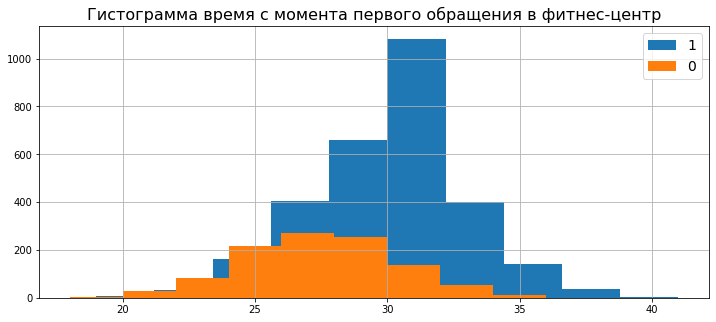

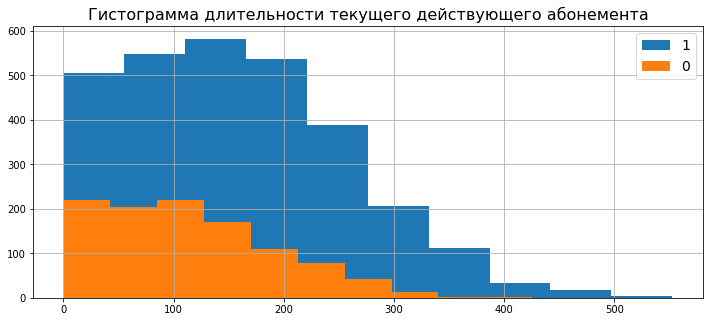

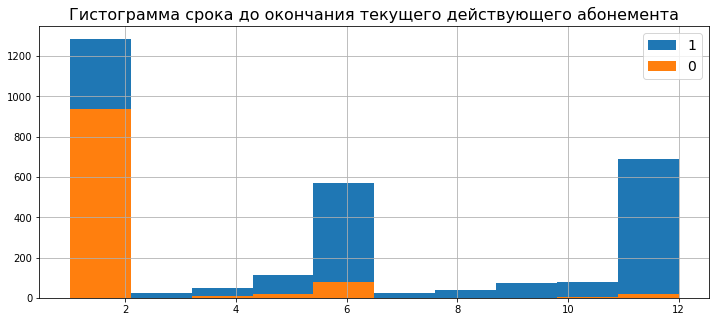

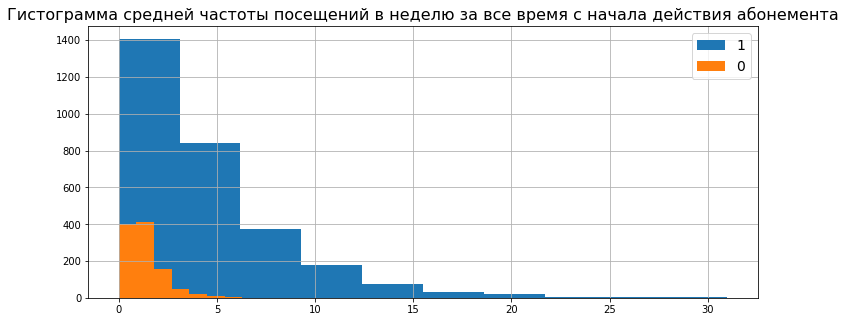

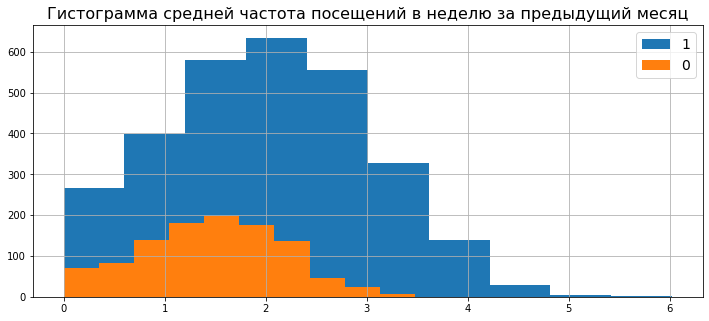

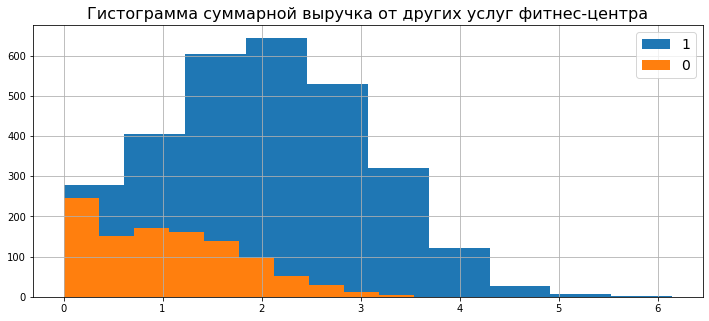

In [33]:
df_churn=df.query('Churn == 1')
df_no_churn=df.query('Churn == 0')
columns_hist=['Age','Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total','Avg_class_frequency_current_month']
columns_name=['Гистограмма время с момента первого обращения в фитнес-центр','Гистограмма длительности текущего действующего абонемента','Гистограмма срока до окончания текущего действующего абонемента','Гистограмма средней частоты посещений в неделю за все время с начала действия абонемента','Гистограмма средней частота посещений в неделю за предыдущий месяц','Гистограмма суммарной выручка от других услуг фитнес-центра']
for x,y in zip(columns_hist,columns_name):    
    plt.figure(figsize=(12,5))
    df_no_churn[x].hist()
    df_churn[x].hist()   
    plt.title(y, fontsize=16)
    plt.legend(['1', '0'], fontsize=14)
    plt.show()

Из этих гистограмм можем сделать следующие выводы:
- Клиенты которые в оттоке, в основном, покупают абономент на один месяц
- Ушедшие клиенты тратят меньше
- Более молодые уходят чаще
- Уходят только новички, если клиент проходил в зал больше 6 месяцев, то скорее всего он останется
- Клиенты в оттоке чаще всего посещают зал 1- 2 раза в неделю
- Если клиент ниразу не посетил зал за месяц, то вероятнее всего он больше не вернется

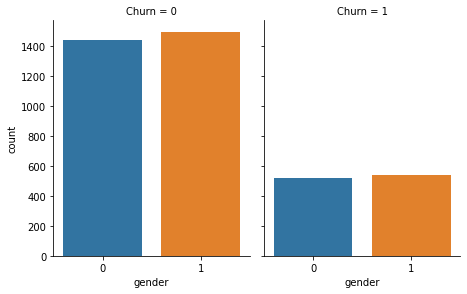

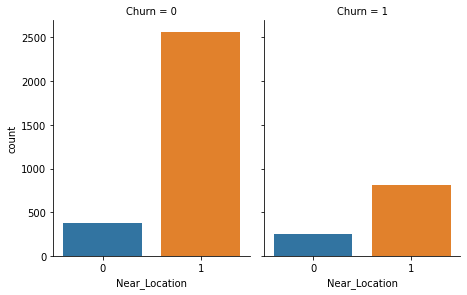

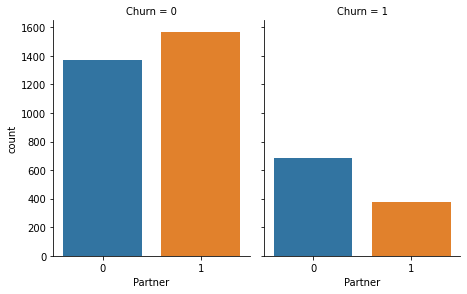

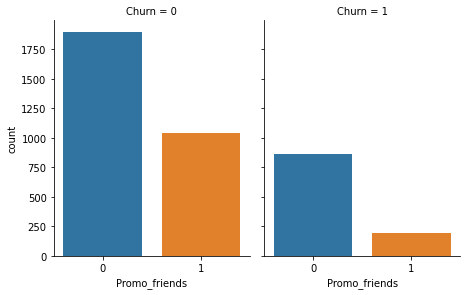

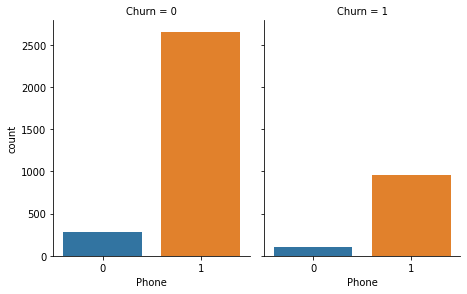

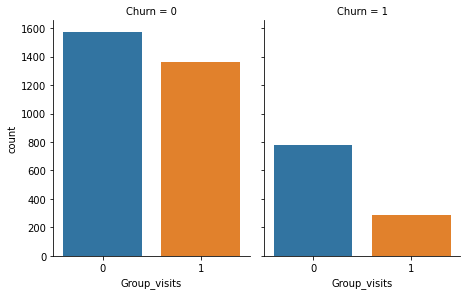

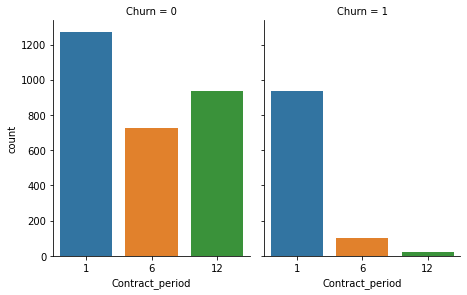

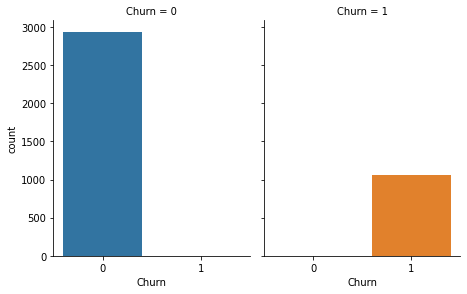

In [34]:
binar_feat = df[['gender', 'Near_Location', 'Partner','Promo_friends', 'Phone', 'Group_visits', 'Contract_period', 'Churn']]
for col in binar_feat.columns:
    sns.catplot(col, col="Churn", data = binar_feat, kind="count", height=4, aspect=.8)

Видим, что чаще уходят клиенты которые:

- Покупают абонемент на один месяц
- Не покупают групповые занятия

Построим матрицу корреляций

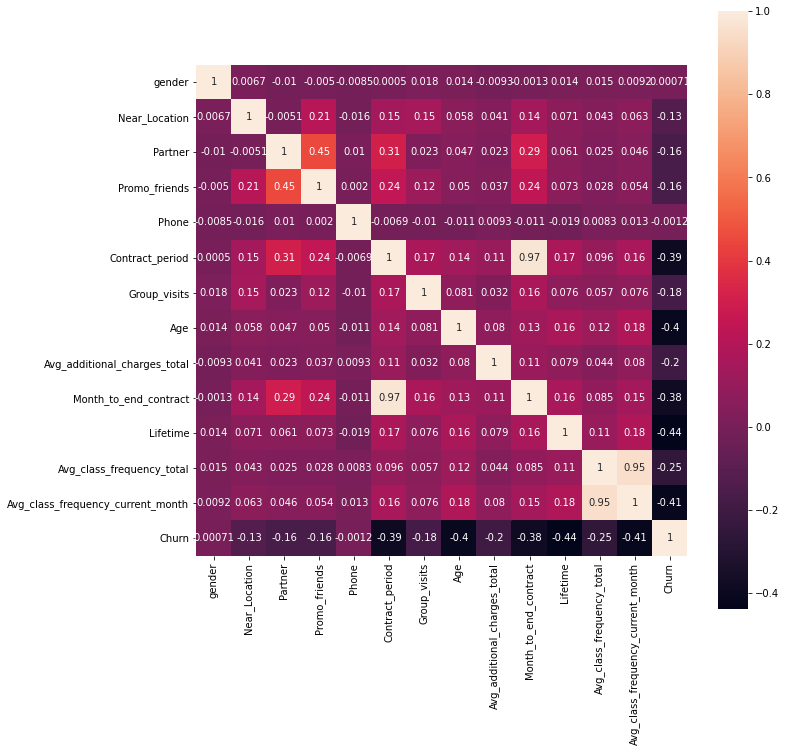

In [35]:
plt.figure(figsize=(11, 11))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

Коррелируют такие признаки как Month_to_end_contract и Contract_period = 0,97, а так же Avg_class_frequency_current_month и Avg_class_frequency_total = 0,95, что логично так как признакми взаимосвязанны между собой. Выделяется так же зависимость между Promo_friends и Partner.

# Шаг 3. Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

In [36]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
# функция, которая вычисляет метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [38]:
# Применяем модель логистической регрессии
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.80
	F1: 0.84
	ROC_AUC: 0.97


In [39]:
# Применяем модель случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.87
	Recall: 0.79
	F1: 0.83
	ROC_AUC: 0.97


Модели отличаются не критично, но модель линейной регресси показала себя лучше, чем модель случайного леса. Так же качество обеих моделей очень высокое 0,96 и 0,97 по ROC_AUC

Рассмотрим важность признаков по двум моделям

In [40]:
log_reg = pd.DataFrame({'feature' : X_train.columns, 'coef' : lr_model.coef_[0]})
log_reg.sort_values(by='coef', ascending=True)

,feature,coef
12,Avg_class_frequency_current_month,-4.577645
10,Lifetime,-0.970260
3,Promo_friends,-0.458858
6,Group_visits,-0.365500
9,Month_to_end_contract,-0.272646
1,Near_Location,-0.127609
7,Age,-0.088346
5,Contract_period,-0.008384
8,Avg_additional_charges_total,-0.003838
2,Partner,0.009821


In [41]:
f_m = pd.DataFrame({'feature' : X_train.columns, 'importance' : rf_model.feature_importances_})
f_m.sort_values(by='importance', ascending=False)

,feature,importance
10,Lifetime,0.279244
12,Avg_class_frequency_current_month,0.170966
11,Avg_class_frequency_total,0.130655
7,Age,0.122138
8,Avg_additional_charges_total,0.085323
9,Month_to_end_contract,0.076873
5,Contract_period,0.068466
6,Group_visits,0.016480
2,Partner,0.011801
0,gender,0.011657


# Шаг 4. Сделаем кластеризацию клиентов

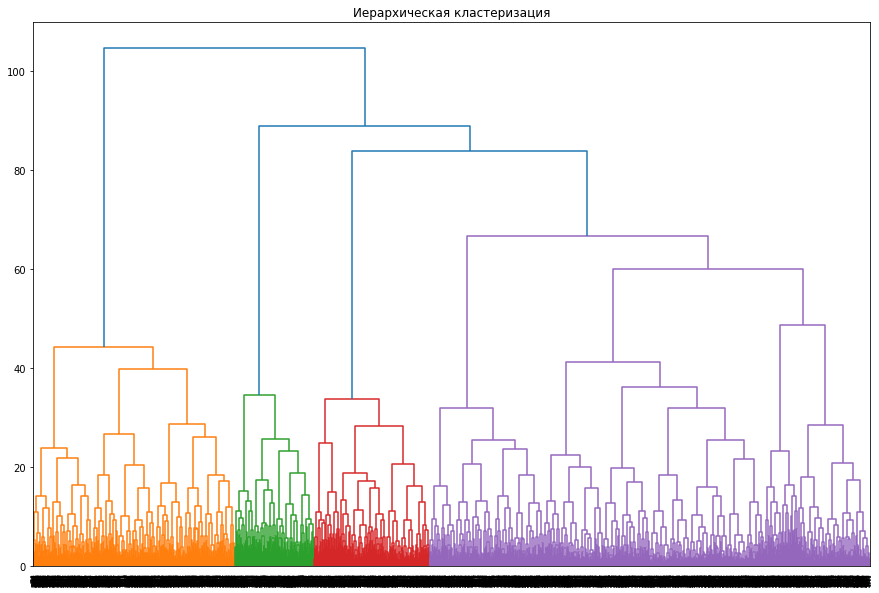

In [42]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

In [43]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)
df_clust_1 = df
df_clust_1['cluster_km'] = labels

In [44]:
# выводим статистику по средним значениям наших признаков по кластеру
df_clust_final = df_clust_1.copy(deep=True)
df_clust_grouped_mean = df_clust_final.groupby('cluster_km').agg('mean')
df_clust_grouped_mean

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Очень высокий отток у 3-го кластера - 51,4%, у 2-го и 3-го кластеров - 26,7% и 44,4% соотвественно, минимальные значения у 4-го и 0-го кластеров - 6,9% и 2,8% 

In [45]:
#Постройте распределения признаков для кластеров
binary_no = df.drop(columns =(['gender', 'Near_Location', 
                              'Partner','Promo_friends', 'Phone',
                              'Group_visits', 'Churn', 'cluster_km','Contract_period', 'Month_to_end_contract', 'Lifetime']))
binary = df[['gender', 'Near_Location', 
                              'Partner','Promo_friends', 'Phone',
                              'Group_visits', 'Contract_period', 'Month_to_end_contract', 'Lifetime']]

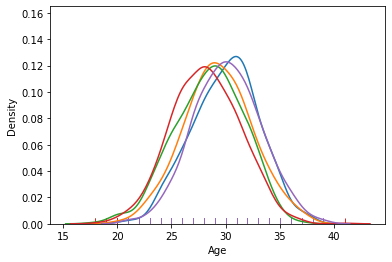

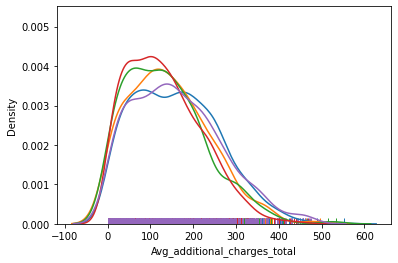

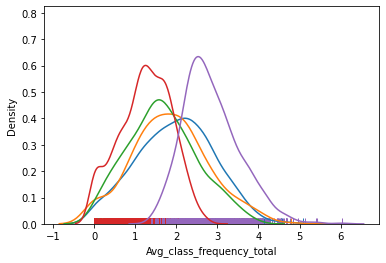

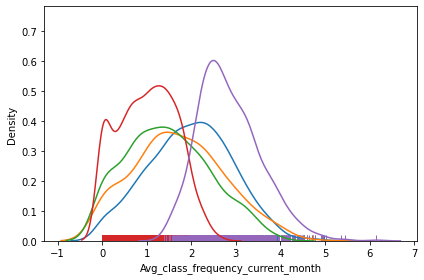

In [47]:
for col in binary_no:
    plt.figure()
    for i in range(0,5):
        sns.distplot(df_clust_1.query('cluster_km == @i')[col],
                    hist=False,
                    rug=True,
                    kde_kws={'label':'Кластер'+ str(i)})
plt.tight_layout()

По графикам можем сделать следующие выводы:
- По графику Age больше всего склонны к оттоку молодые ребята, на пике 28 лет(3-й кластер), а надежные кластеры самые возрастные 0-й кластер на пике 32 года, 4-й на пике 30 лет.
- Что касается доп.затрат - более надежные кластеры имеют более широкий график, большинство клиентов 3-го тратят меньше, далее 2-й и 3-й кластер.
- Самый активный кластер 4-й, в среднем 3 посещения в неделю. Минимальная активность наблюдается у 3-го кластера, в среднем 1 занятие в неделю. Чем клиент активнее в теченеии недели посещяет зал, тем меньше вероятность его оттока
- Месячная посещяемсоть, схожа с динамикой посещений в неделю

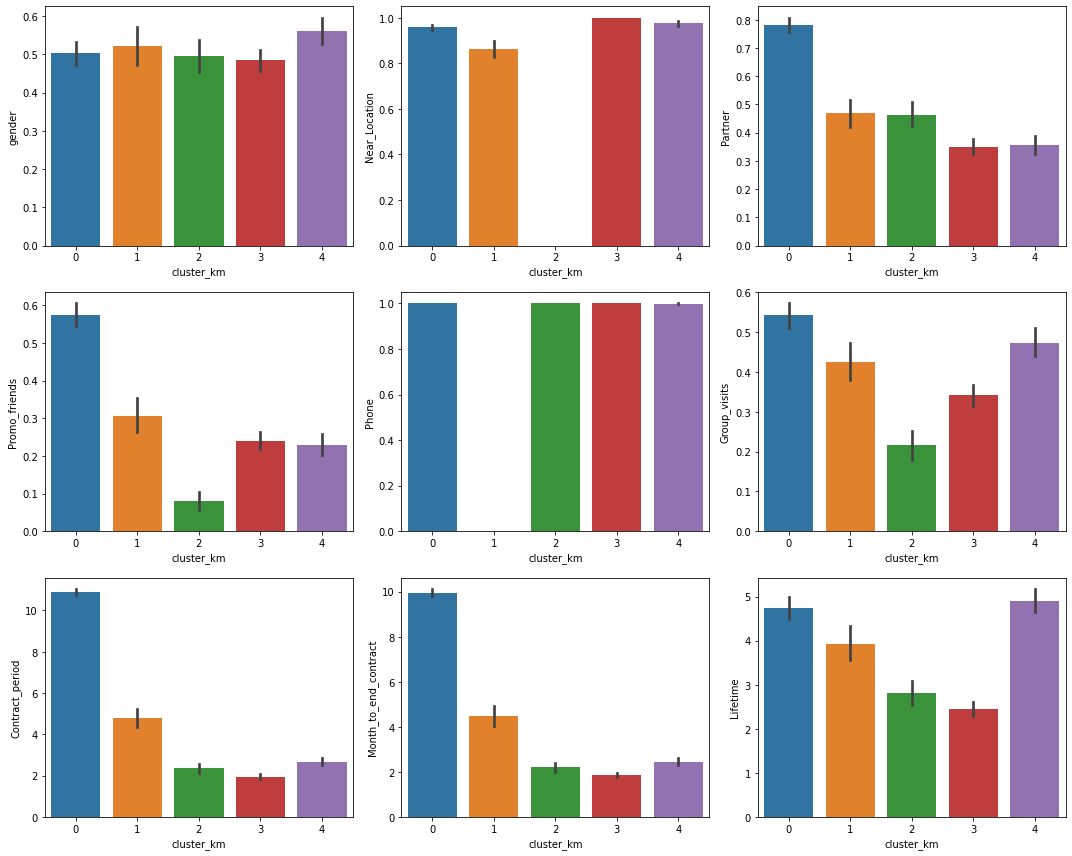

In [48]:
plt.figure(figsize=(15,12))
for i in range(len(binary.columns)):
    plt.subplot(3,3,i+1)
    x = df_clust_1['cluster_km']
    y = binary.iloc[:,i]
    sns.barplot(x=x, y=y)
plt.tight_layout()
plt.show()

Промежуточные выводы:
- Динамика Lifetime(время с момента первого посещения), новые клиенты больше всего подвержены к оттоку
- 1-й кластер не оставил ни одоного телефонного номера
- Клиента 2-го кластера живут или работают не рядом с фитнесом
- Активнее всего посещают груповые занятия клиенты в 0-ом кластере, что логично, так как у них самый высокий показатель Partner и Promo_frinds, значит у них много знакомых, кто ходит вместе с ними на тренировки

# Вывод

Стоит обратить большее внимание на новых клиентов, так как этот признак самый влиятельный на отток. А так же на то, что их траты на пике выше всех остальных кластеров, именно поэтому для новых клиентов нужно создать акции и дополнительные скидки чтобы увеличить их Retention rate. Новички покупают абонеменет на один месяц, нужно предложить только для новых клиентов абономент на 3 месяца + возможность посетить платные занятие бесплатно, так они смогу познакомиться с уже постоянными клиентами, а это очень важно. Так же нужно уделить внимание акции Приведи друга и для новых клиентов, кто купил абонемент, например не на 1 месяц, а на 6, он получит дополнительный абонемент для друга бесплатно. В остальном же постоянные клиенты имеют малую склонность к оттоку, но так же имеют тенденцию покупать абонемент на один месяц, стоить создать программу лояльности, таким образом уменьшится вероятность оттока постоянных клиентов.